In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPool1D, LSTM, Dense, Dropout

from keras import backend as K
from tensorflow import keras

import numpy as np

In [4]:
import os
from data import generate_train_data

cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb" in x]
# cases = ["chb01", "chb02"]
# generate_train_data(sequence_length=256, stride=256, cases=cases)

In [41]:
from seizure_sequence import SeizureSequence
from preprocessor import PreProcessor

p = PreProcessor(wavelet="db4")
seizure_sequence = SeizureSequence(1, "ml_processed_balanced", cases, bias_positive=False, preprocessor=p)
data, labels = seizure_sequence.__getitem__(1)
# for inddata in data:
#     if inddata.shape != (23, 256):
#         print(inddata.shape)

In [7]:
def create_model():
    model = Sequential()

    model.add(Input((23, 256, )))
    model.add(Conv1D(512, kernel_size=3, activation="relu"))
    model.add(MaxPool1D())
    model.add(Conv1D(256, kernel_size=3, activation="relu"))
    model.add(MaxPool1D())
    model.add(Conv1D(128, kernel_size=3, activation="relu"))
    model.add(MaxPool1D())
    # model.add(LSTM(64, activation="tanh"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    return model

model = create_model()

In [8]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 512)           393728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 256)            393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 128)           0

In [18]:
# tf_dataset = seizure_sequence.create_tf_dataset()
history = model.fit(seizure_sequence, epochs=1)

184/184 [==============================] - 2s 10ms/step - loss: 0.0794 - accuracy: 0.9719


after 500 epochs of training on the balanced dataset with 885k params (all conv), accuracy is 94.9%

after 500 epochs of training on the balanced dataset with 935k params (conv, 1 64 LSTM layer), accuracy is 98.5%

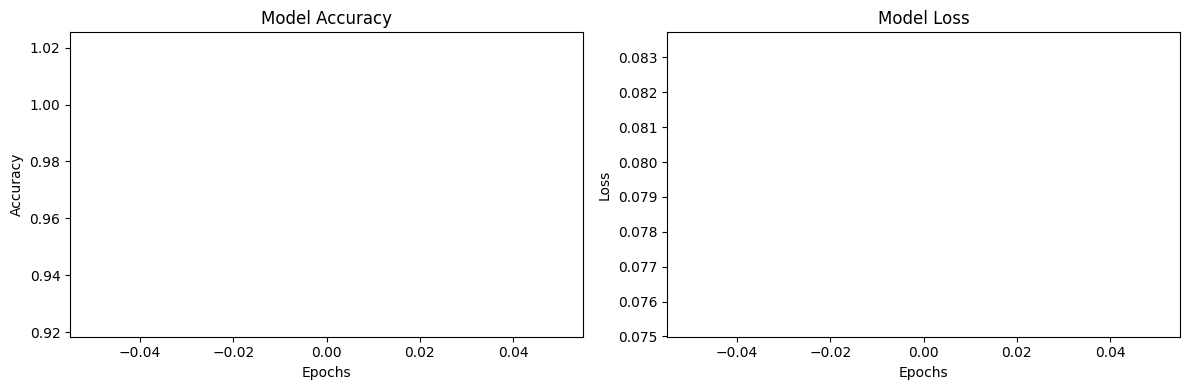

In [19]:
import matplotlib.pyplot as plt
# Plotting accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [31]:
data = np.load("ml_processed/chb01_03.edf_data.npy")
labels = np.load("ml_processed/chb01_03.edf_labels.npy")
# for i in range(0, len(labels)):
#     if labels[i][0] == 1:
#         print(i)
# print(data.shape)
known_seizures = data[3000:3020]
# print(known_seizures.shape)
known_seizure_label = labels[3000:3020]
for label in known_seizure_label:
    if label == 0:
        print("OOPS")

seizure_guesses = []
for known_seizure in known_seizures:
    # print(known_seizure.shape)
    reshaped = np.reshape(known_seizure, (-1, 23, 256))
    guess = model.predict(reshaped)
    if guess[0][0][0] > 0.4:
        seizure_guesses.append((guess[0][0][0], 1))
    else:
        seizure_guesses.append((guess[0][0][0], 0))

known_normal = data[0:20]
# print(known_seizures.shape)
known_normal_label = labels[0:20]
for label in known_normal_label:
    if label == 1:
        print("OOPS")


normal_guesses = []
for known_normal in known_normal:
    # print(known_seizure.shape)
    reshaped = np.reshape(known_normal, (-1, 23, 256))
    guess = model.predict(reshaped)
    if guess > 0.4:
        normal_guesses.append((guess[0][0][0], 1))
    else:
        normal_guesses.append((guess[0][0][0], 0))

1/1 [==============================] - 0s 18ms/step


In [34]:
print(seizure_guesses)
print(normal_guesses)

[(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (0.9997178, 1), (0.9993801, 1), (0.9999583, 1), (0.999997, 1), (0.9942365, 1), (0.9994636, 1), (0.9995732, 1), (0.99848026, 1), (0.9999999, 1), (1.0, 1), (0.99999714, 1), (0.9994487, 1), (1.0, 1)]
[(0.01409787, 0), (0.0018650282, 0), (0.0012986226, 0), (0.0129272435, 0), (0.0038680271, 0), (0.005158884, 0), (0.0027653961, 0), (0.0021415632, 0), (0.00011696083, 0), (0.00035668066, 0), (0.0017261656, 0), (0.0052052285, 0), (0.00032098882, 0), (0.0004237193, 0), (0.022003619, 0), (0.07114024, 0), (0.00070355594, 0), (0.0009241222, 0), (0.0005796507, 0), (0.0011063754, 0)]


had to drop chb12-27, the sensors changed and they are different from everything else.

In [13]:
# from data import generate_balanced_train_data
# import os
# cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb" in x]
# generate_balanced_train_data(256,256,cases)